In [1]:
from typing import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import os

load_dotenv()

GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")

/opt/anaconda3/envs/langchainAcademy/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [5]:
from langgraph.graph import StateGraph, START,END
from langgraph.checkpoint.memory import MemorySaver
class State(TypedDict):
    foo: int

def node1(state:State):
    return {'foo': state['foo'] + 1}

builder = StateGraph(State)
builder.add_node('node1', node1)
builder.add_edge(START, 'node1')
graph_memory = builder.compile(checkpointer = MemorySaver())

In [4]:
config = {'configurable': {'thread_id':1}}
graph_memory.invoke({'foo':3}, config)

{'foo': 4}

### Lets look at a simple case of branching

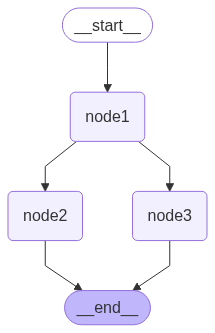

In [6]:
def node2(state:State):
    return {'foo': state['foo'] + 1}

def node3(state:State):
    return {'foo': state['foo'] + 1}

builder = StateGraph(State)
builder.add_node('node1', node1)
builder.add_node('node2', node2)
builder.add_node('node3', node3)

# LOGIC
builder.add_edge(START, 'node1')
builder.add_edge('node1', 'node2')
builder.add_edge('node1', 'node3')
builder.add_edge('node2', END)
builder.add_edge('node3', END)

graph = builder.compile(checkpointer = MemorySaver())

graph

In [9]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({'foo': 1}, config)
except InvalidUpdateError as e:
    print('invalid update', e)



invalid update At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


### Reducers help in solving this problem, we can specify how we want updates to be made if 2 nodes are updating same data in the same step

In [21]:
from typing import Annotated
from operator import add
class States(TypedDict):
    foo: Annotated[list[int], add]

# now this appends

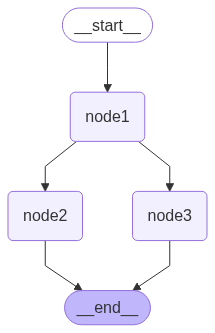

In [25]:
def node1(state:States):
    return {'foo': [state['foo'][-1] + 1]}
    
def node2(state:States):
    return {'foo': [state['foo'][-1] + 1]}

def node3(state:States):
    return {'foo': [state['foo'][-1] + 1]}

builder = StateGraph(States)
builder.add_node('node1', node1)
builder.add_node('node2', node2)
builder.add_node('node3', node3)

# LOGIC
builder.add_edge(START, 'node1')
builder.add_edge('node1', 'node2')
builder.add_edge('node1', 'node3')
builder.add_edge('node2', END)
builder.add_edge('node3', END)

graph = builder.compile(checkpointer = MemorySaver())

graph

In [31]:
from langgraph.errors import InvalidUpdateError


graph.invoke({'foo': [1]}, config)

{'foo': [1,
  2,
  3,
  3,
  1,
  2,
  3,
  3,
  1,
  2,
  3,
  3,
  1,
  2,
  3,
  3,
  1,
  2,
  3,
  3,
  1,
  2,
  3,
  3]}

### We can create a custom reducer

In [32]:
def custom_add(a, b):
    ''' adds two lists '''
    if not a:
        a = []
    if not b :
        b = []
    return a + b

class States(TypedDict):
    foo: Annotated[list[int], custom_add]